In [55]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import time
import numpy as np



In [56]:
df = pd.read_csv('SAdata_allMeasures.csv')

y = df['Y']
X = df.drop(columns=['Y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
df.head()

(843, 28)


,age,gender,yearDriving,drivingFrequency,temp_length,temp_decisiontime,temp_decision_made,temp_correct_decision,temp_danger,temp_difficulty,...,fMax,backMirror,leftMirror,rightMirror,road,sky,pupilChange,pupilMean,pupilStd,Y
0,26,1,20,1,12,4.80219,4,2,20,89,...,874.5,0,5,3,24,0,0.733955,3.818149,0.169227,0.641219
1,26,1,20,1,6,4.91667,1,2,10,99,...,1014.0,2,2,1,9,2,0.623622,3.743575,0.178412,0.354868
2,26,1,20,1,1,2.21716,2,2,99,99,...,259.5,0,0,0,3,0,0.205836,3.326857,0.079828,0.561225
3,26,1,20,1,3,2.63056,1,2,9,79,...,636.0,0,1,0,6,0,0.020505,3.643468,0.034005,0.422067
4,26,1,20,1,9,2.42632,1,2,9,96,...,807.0,5,4,1,13,0,0.632357,3.669544,0.196699,0.533333


## Baseline LR

In [57]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_predictions = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_predictions)
print("Linear Regression Mean Squared Error:", linear_mse)

linear_r2 = r2_score(y_test, linear_predictions)
print("Linear Regression R-squared:", linear_r2)

Linear Regression Mean Squared Error: 0.013088468386775005
Linear Regression R-squared: 0.22664746493344456


## XGB

In [58]:
start_time_xgb = time.time()
eval_set_xgb = [(X_train, y_train), (X_test, y_test)]
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=2, random_state=42)
model_xgb.fit(X_train, y_train, eval_set=eval_set_xgb, verbose=False)
xgb_training_time = time.time() - start_time_xgb

start_predict_xgb = time.time()
xgb_predictions = model_xgb.predict(X_test)
xgb_prediction_time = time.time() - start_predict_xgb

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# LGB

In [59]:
# Add timing and evaluation for LightGBM
start_time_lgb = time.time()
eval_set_lgb = [(X_train, y_train), (X_test, y_test)]
model_lgb = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2, # Decreasing it made the rmse lower
    min_data_in_leaf=3,  # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    random_state=42
)

model_lgb.fit(
    X_train, 
    y_train,
    eval_set=eval_set_lgb,
    eval_metric='l2',
)
lgb_training_time = time.time() - start_time_lgb

start_predict_lgb = time.time()
lgb_predictions = model_lgb.predict(X_test)
lgb_prediction_time = time.time() - start_predict_lgb

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 843, number of used features: 28
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Start training from score 0.286042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

## REPORT

In [60]:
import matplotlib.pyplot as plt

In [61]:
performance_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'RMSE': [xgb_rmse, lgb_rmse],
    'MAE': [xgb_mae, lgb_mae],
    'R²': [xgb_r2, lgb_r2],
    'Training Time (s)': [xgb_training_time, lgb_training_time],
    'Prediction Time (s)': [xgb_prediction_time, lgb_prediction_time]
})


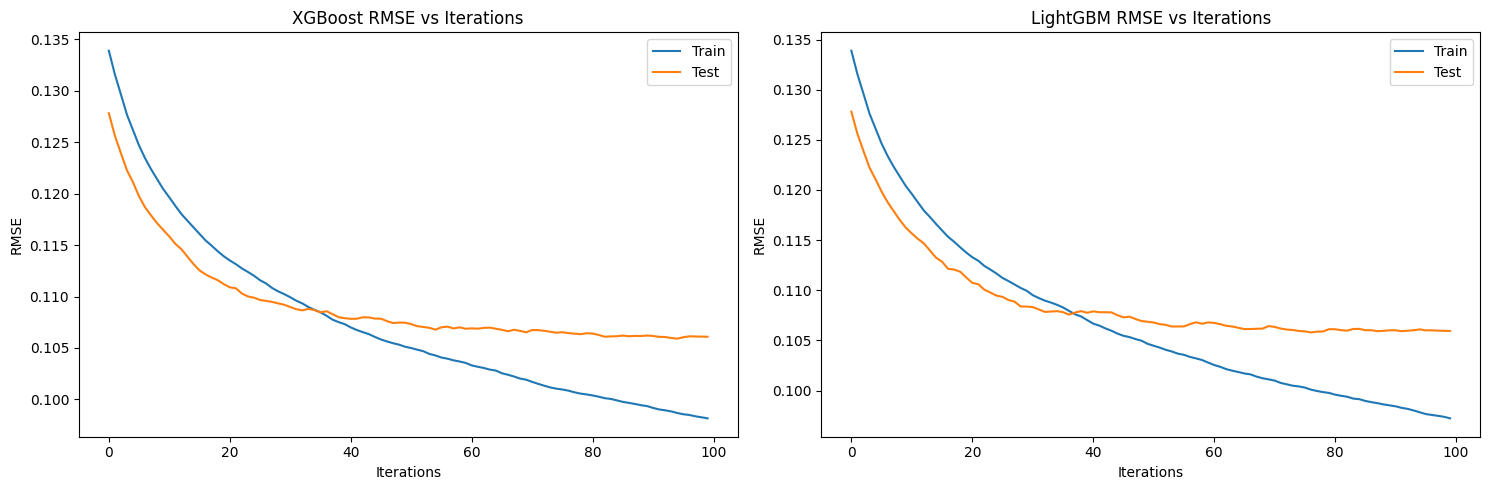


Model Performance Comparison:
   Model     RMSE      MAE       R²  Training Time (s)  Prediction Time (s)
 XGBoost 0.106094 0.084165 0.334926           0.181889             0.003541
LightGBM 0.105943 0.083960 0.336823           0.082056             0.000889


In [62]:

plt.figure(figsize=(15, 5))

# XGBoost training progress
plt.subplot(1, 2, 1)
results_xgb = model_xgb.evals_result()
epochs_xgb = len(results_xgb['validation_0']['rmse'])
x_axis_xgb = range(epochs_xgb)
plt.plot(x_axis_xgb, results_xgb['validation_0']['rmse'], label='Train')
plt.plot(x_axis_xgb, results_xgb['validation_1']['rmse'], label='Test')
plt.legend()
plt.title('XGBoost RMSE vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('RMSE')

# LightGBM training progress
plt.subplot(1, 2, 2)
results_lgb = model_lgb.evals_result_
epochs_lgb = len(results_lgb['training']['l2'])
x_axis_lgb = range(epochs_lgb)
plt.plot(x_axis_lgb, np.sqrt(results_lgb['training']['l2']), label='Train')
plt.plot(x_axis_lgb, np.sqrt(results_lgb['valid_1']['l2']), label='Test')
plt.legend()
plt.title('LightGBM RMSE vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

# Print performance table
print("\nModel Performance Comparison:")
print(performance_df.to_string(index=False))